In [117]:
# import
%pip install --upgrade pip
%pip install -q langchain-nvidia-ai-endpoints
%pip install -q langchain
%pip install -q langchain-community 
%pip install -q langchain-core
%pip install -q langchain-text-splitters
%pip install -q langchain-openai
%pip install -q chromadb
%pip install pysqlite3-binary
%pip install -q pymupdf
%pip install pypdf
%pip install -q langgraph
%pip install langchain_tavily

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [118]:
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [119]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, NVIDIARerank
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import VLLM
from langchain_openai import OpenAI
import os

## Tavily API Key Note

**Important:** The web search functionality in this notebook relies on the Tavily API. Tavily offers free API credits, which are sufficient for demonstration purposes.

To use Tavily, you will need to:
1.  Visit the Tavily pricing page: [https://www.tavily.com/#pricing](https://www.tavily.com/#pricing)
2.  Create an account.
3.  Generate your personal API key from your account dashboard.
4.  Replace the placeholder `TAVILY_API_KEY` in the `Environment Configuration` section with your actual key.

# Configure API keys and service URLs.


In [156]:
TAVILY_API_KEY = "replace with your token"
EMBEDDING_API_URL = "http://llama-32-nv-nvidia-nims.apps.rtp-ai2-ucs.svpod.dc-01.com/v1"
LLM_API_URL = "http://llm-d-inference-gateway-istio.llm-d.svc.cluster.local/v1"
MCP_SERVER_URL = "http://172.30.243.120:8000/mcp"

In [157]:
from langchain_community.tools import TavilySearchResults
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
web_search_tool = TavilySearchResults(max_results=5)

# embedding model

In [122]:
# Initialize the NVIDIAEmbeddings model.
# This model converts text into numerical vectors (embeddings), which are used for
# semantic search and similarity comparisons in the vector store.

embeddings = NVIDIAEmbeddings(
    base_url=EMBEDDING_API_URL, 
    model="nvidia/llama-3.2-nv-embedqa-1b-v2",
    truncate="END"
)

# LLM instantiation with ChatOpenAI

In [123]:
# LLM
# This LLM is responsible for understanding prompts, generating responses, and grading relevance.

model_id = "llama4"

llm = ChatOpenAI(
    base_url=LLM_API_URL,
    api_key="abc",
    model=model_id, 
    temperature=0,
    max_tokens=None,
    )


# doc loader

In [124]:
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import CharacterTextSplitter,RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

# Set PDF directory to the document path

pdf_directory = "./"  # Assumes PDFs are in the same directory as the notebook.

# Load PDF documents
pdf_dir_loader = PyPDFDirectoryLoader(pdf_directory)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=512, chunk_overlap=64)
doc_splits = text_splitter.split_documents(docs)


# Add the processed document splits to a Chroma vector store.
# The embeddings model is used to convert text chunks into vectors.
# This vector store will be used for RAG.

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="test",
    embedding=embeddings,
    persist_directory="./vectordb",
)
retriever = vectorstore.as_retriever()

In [125]:
# Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import JsonOutputParser


prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()


In [126]:
# test document Retrieval

question = "What are the key features of Cisco UCS servers?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


# MCP Server Connection and Tool Retrieval

This section defines functions to establish a connection with the Cisco Intersight MCP server and retrieve available tools. These tools allow the AI agent to perform specific actions or fetch data from Intersight.

In [127]:
import requests
import json

def mcp_server_call(headers, payload):
    try:
        response = requests.post(MCP_SERVER_URL, headers=headers, json=payload)
        # Check if the request was successful
        if response.ok:
            return response
        else:
            print(f"Request failed with status code: {response.status_code}")
            return response.text
    except requests.exceptions.ConnectionError as e:
        print(f"Connection Error: Could not connect to {MCP_SERVER_URL}. Is the server running?")
        print(e)
    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the request: {e}")


        
def get_tools():
    # Initialize the variable to store the session ID
    mcp_session_id = None
        
    # Define the headers
    initialize_headers = {
        "Content-Type": "application/json",
        "Accept": "application/json, text/event-stream"
    }
    
    # Define the JSON payload
    initialize_payload = {
        "method": "initialize",
        "params": {
            "protocolVersion": "2024-11-05",
            "capabilities": {
                "roots": {"listChanged": True},
                "sampling": {}
            },
            "clientInfo": {
                "name": "curl-client",
                "version": "1.0.0"
            }
        },
        "jsonrpc": "2.0",
        "id": 1
    }
    
    initialize_response = mcp_server_call(initialize_headers, initialize_payload)
    
    # Check if the request was successful (status code 2xx)
    if initialize_response.ok:
        print("Request successful. Retrieving mcp session id")
        mcp_session_id = initialize_response.headers.get("mcp-session-id")
    else:
        print("Request failed.")
        print("Response Text:")
        print(initialize_response.text)

    # sending initialized notification

    notification_headers = {
        "Content-Type": "application/json",
        "Accept": "application/json, text/event-stream",
        "Mcp-Session-Id": mcp_session_id
    }
    
    # Define the JSON payload
    notification_payload = {
        "method": "notifications/initialized",
        "params": {},
        "jsonrpc": "2.0"
    }
    
    notification_response = mcp_server_call(notification_headers, notification_payload)
    
    # Check if the request was successful (status code 2xx)
    if notification_response.ok:
        print("Request successful. Notification sent")
    else:
        print("Request failed.")
        print("Response Text:")
        print(notification_response.text)

    list_headers = {
    "Content-Type": "application/json",
    "Accept": "application/json, text/event-stream",
    "Mcp-Session-Id": mcp_session_id
    }
    
    # Define the JSON payload
    list_payload = {
        "method": "tools/list",
        "params": {},
        "jsonrpc": "2.0",
        "id": 2
    }
    
    list_response = mcp_server_call(list_headers, list_payload)
    
    # Check if the request was successful (status code 2xx)
    if list_response.ok:
        print("Request successful. Retrieving tools.")
        retrieved_tools = list_response.text
        # print(retrieved_tools)
        
        #clean json
        tools = clean_json(retrieved_tools)
        tools = tools['result']['tools']
        # print(tools)
        
        return tools, mcp_session_id
    else:
        print("Request failed.")
        print("Response Text:")
        print(list_response.text)

#clean json
def clean_json(json_data):
    for line in json_data.splitlines():
        if line.startswith("data:"):
            data_section = line[len("data:"):].strip()
            break
    
    # Parse the JSON string
    cleaned_json = json.loads(data_section)
    
    # Now, data_json is a dictionary you can use
    return cleaned_json

In [128]:
tools, mcp_session_id = get_tools()


Request successful. Retrieving mcp session id
Request successful. Notification sent
Request successful. Retrieving tools.


In [129]:
# Display the retrieved tools. This shows what functionalities the agent can leverage
# from the Intersight MCP server.

tools

[{'name': 'make_intersight_request',
  'description': 'Make a request to the Intersight API with proper error handling.',
  'inputSchema': {'properties': {'url': {'title': 'Url', 'type': 'string'}},
   'required': ['url'],
   'title': 'make_intersight_requestArguments',
   'type': 'object'}},
 {'name': 'get_ntp_policies',
  'description': '\n    Use Intersight API to retrieve Cisco ntp policies, mention moid to filter specific moid. Empty input "" will return all available ntp policies\n    ',
  'inputSchema': {'properties': {'moid': {'default': 'Use Intersight API to retrieve Cisco ntp policies, mention moid to filter specific moid. Empty input  will return all available ntp policies.',
     'title': 'moid',
     'type': 'string'}},
   'title': 'get_ntp_policiesArguments',
   'type': 'object'}},
 {'name': 'get_compute_rackunits_by_site',
  'description': 'Retrieve detailed Cisco Compute rack unit information from Intersight API using site as input which looks like rtp, sng, lon, etc.,

# Router 
The router prompt is crucial for directing the user's question to the most appropriate component: an MCP tool, the vector store (for UCS-related queries), a web search, or a general chat interaction.

In [130]:
from langchain import PromptTemplate

router_prompt = PromptTemplate(
    input_variables=["question", "tools"],
    template="""
<|begin_of_text|><|header_start|>system<|header_end|>
You are an expert at routing a user question to a tool, vectorstore or web search.
Available Tools: {tools}

Your task is to:

1. Analyze the user question.
2. Select and return the correct tool(s) from the list of available tools if relevant.
3. If no tools match the question, determine whether to search a vectorstore or perform a web search based on the question topic.
   - Use **vectorstore** only if the question is related to Cisco UCS servers or their components. Be flexible with keywords, but do not select vectorstore for general, personal, or unrelated queries.
   - Use **web_search** for queries that can be found on the internet
   - Use **chat** for normal chatting interaction with users
4. Return **only one** JSON response **without any extra explanation or text**.

The JSON response must always include the keys `"tool_calls"` and `"datasource"`:

- `"tool_calls"`: an array of zero or more tool call objects.
- `"datasource"`: a string with one of the values:
   - `"tool"` if one or more tools are called.
   - `"vectorstore"` or `"web_search"` or `"chat"` if no tools are called.

Examples:
- If one or more tools match the question:

{{
  "tool_calls": [
    {{
      "name": "toolName1",
      "parameters": {{
        "key1": "value1"
      }}
    }}
  ],
  "datasource":"tool"
}}

- If no tools match, return:

{{
  "tool_calls": [],
  "datasource": "vectorstore"  // "web_search" or chat
}}

<|eot_id|><|header_start|>user<|header_end|>

User question: {question}
<|eot_id|><|header_start|>assistant<|header_end|>
"""
)


In [131]:
### Test Router

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser


question_router = router_prompt | llm | JsonOutputParser()
question = "tell me about john cena?"

print(question_router.invoke({"question": question, "tools": tools, "chat_history": 'test'}))

{'tool_calls': [], 'datasource': 'web_search'}


# Generate output 

This chain is used for generating answers based on retrieved context.

In [132]:
### Generate

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
rag_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
Question: {question} 
Context: {context} 
Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "context"],
)
rag_chain = rag_prompt | llm | StrOutputParser()


# Chat output
This chain handles general conversational interactions when a specific tool or RAG retrieval isn't necessary.

In [133]:
chat_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a friendly chatbot that interacts with users. 
    Answer any question with the best of your abilities with the available context. Answer truthfully and friendly 
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Chat History: {chat_history}
    Question: {question} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "chat_history"],
)

# Chain
chat_chain = chat_prompt | llm | StrOutputParser()

# Graders (Hallucination & Answer)


These graders evaluate the quality of the generated answers. The Hallucination Grader checks if the answer is grounded in the provided documents, and the Answer Grader assesses if the answer is useful and addresses the user's question.

In [134]:
### Hallucination Grader

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
You are a grader assessing whether an answer is grounded in / supported by a set of facts. 
Give a binary 'yes' or 'no' score to indicate whether the answer is grounded in the provided documents. 

Provide the result as a JSON object with a single key 'score' and no preamble or explanation.

Example:
{{"score": "yes"}} or {{"score": "no"}}

<|eot_id|><|start_header_id|>user<|end_header_id|>
Here are the facts:
-------
{documents}
-------
Here is the answer: {generation}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()


In [135]:
### Answer Grader

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()


# Langgraph Workflow Definition

This is the core of the agent's logic, defining how different components (nodes) interact and transition based on the current state and decisions. Langgraph allows for complex, stateful agent behaviors.


# Graph State

The GraphState defines the structure of information that flows through the Langgraph workflow.

In [136]:
from typing_extensions import TypedDict
from typing import List
from langchain.schema import Document
from langchain_core.messages import BaseMessage

############# State #################

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add internet search
        tool_info: list of tools
        documents: list of documents
        session_id: uuid for conversation memory
    """

    question: str
    generation: str
    web_search: str
    tool_info: dict
    tools: dict
    documents: List[str]
    config: dict
    chat_history: List[BaseMessage]
    messages: List[BaseMessage]

In [137]:
import random    
import uuid
def load_session_id():
    
    session_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": session_id}}
    return session_id, config

In [138]:
def load_chat_history(config):
    print("Session ID input, loading previous chat...")
    chat_history = list(app.get_state_history(config))
    # print("config: ", config)
    
    return chat_history

In [139]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage # Import necessary message types

def retrieve_chat_history(state: GraphState, config: RunnableConfig) -> GraphState:
    print("---Loading chat history---")

    current_question = state.get("question", "")
    tools = state.get("tools", [])
    chat_history = state.get("chat_history", [])
    thread_id = config['metadata']['thread_id']
    config = {"configurable": {"thread_id": thread_id}}
    return {"chat_history": chat_history, "question": current_question, "tools": tools, "thread_id": thread_id}

In [140]:
from typing import Literal
from langgraph.types import Command
from langchain_core.runnables import RunnableConfig

def route_question(state: dict, config: RunnableConfig) -> Command[Literal["mcp_tool", "websearch", "vectorstore", "chat"]]:
    """
    Route question to tool, web search, or RAG.

    Args:
        state (dict): Current state

    Returns:
        Command: encapsulating state update and next node to go to
    """

    print("---ROUTE QUESTION---")
    question = state.get("question", "")
    tools = state.get("tools", [])
    chat_history = state.get("chat_history", [])


    global router_status, router_choice, routing_agent_panel_content

    target_source = question_router.invoke({"question": question, "tools": tools, "chat_history": chat_history})

    print(target_source)
    func_name = ""
    func_params = {}


    if isinstance(target_source, dict):
        if "datasource" in target_source:
            router_choice = target_source["datasource"]
            print(router_choice)

            if router_choice == "tool":
                print("---DECISION: ROUTE QUESTION TO TOOL---")
                router_status = "success"
                tool_calls = target_source.get("tool_calls", [])
                if tool_calls and isinstance(tool_calls, list):
                    first_func = tool_calls[0]
                    func_name = first_func.get("name", "")
                    func_params = first_func.get("parameters", {})
                    
            elif router_choice == "web_search":
                print("---DECISION: ROUTE QUESTION TO WEB SEARCH---")
                router_status = "success"

            elif router_choice == "vectorstore":
                print("---DECISION: ROUTE QUESTION TO RAG---")
                router_status = "success"

            elif router_choice == "chat":
                print("---DECISION: ROUTE QUESTION TO CHAT---")
                router_status = "success"

            else:
                print(f"Warning: Unknown datasource '{router_choice}', defaulting to websearch")
        else:
            print("Error: 'datasource' key not found in source")
    else:
        print("Error: source is not a dictionary")

    update = {
        "tool_info": {
            "func_name": func_name,
            "func_params": func_params
        },
    }

    next_node_map = {
        "tool": "mcp_tool",
        "web_search": "websearch",
        "vectorstore": "vectorstore",
        "chat": "chat"
    }

    # Default to 'websearch' if unknown
    next_node = next_node_map.get(router_choice, "websearch")

    return Command(update=update, goto=next_node)


In [141]:
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    
    if hasattr(question, 'content'):
        question = question.content
    else:
        question = question

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}


In [142]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state.get("question", "")
    documents = state.get("documents", [])
    global relevant_count
    relevant_count = 0

    # Score each doc
    filtered_docs = []
    web_search = "Yes"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
            relevant_count += 1
            web_search = "Yes"
        # Document not relevant
        else:            
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            continue

    global relevance_report_msg
    
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [143]:
def chat(state, config):
    """
    Normal chatbot without any grounding except for chat history.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---CHATTING---")
    question = state.get("question", "")
    # print(question)
    chat_history = state.get("chat_history", []) 
    # print("chat_history @chat: ", chat_history)

    # Chat generation
    chat_response = chat_chain.invoke({"question": question, "chat_history": chat_history})

    build_history = {'question': question, 'generation': AIMessage(content=chat_response)}

    chat_history.insert(0, build_history)
    
    return {"question": question, "generation": chat_response, "chat_history": chat_history}

In [144]:
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    # Check if 'documents' key exists in state, if not, initialize it
    if "documents" not in state:
        state["documents"] = []

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    if hasattr(question, 'content'):
        question = question.content
    else:
        question = question
        
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]

    global relevance_report_msg
    
    relevance_report_msg = f"""
            <p style="font-size: large;">
                The current query does not pertain to UCS server details. The request has been redirected to a web search for further assistance.
            </p>
        """
    return {"documents": documents}

In [145]:
import requests

def tool_call(state):
    """
    Tool call based on the routed question.

    Args:
        state (dict): The current graph state

    Returns:
        dict: Updated state with appended tool results documents and question
    """

    print("---Sending request to MCP tool---")
    routing_info = state.get("tool_info", {})

    func_name = routing_info.get("func_name", "")
    func_params = routing_info.get("func_params", {})
    print("func_name, func_params",  func_params, func_name)

    question = state.get("question", "")
    documents = state.get("documents", None)

    if not func_name:
        print("No tool function specified.")
        return {"documents": documents, "question": question}


    # call tool
    tool_call_headers = {
        "Content-Type": "application/json",
        "Accept": "application/json, text/event-stream",
        "Mcp-Session-Id": mcp_session_id
    }
    
    # Define the JSON payload
    tool_call_payload = {
        "method": "tools/call",
        "params": {"name": func_name,
                   "arguments": func_params,
                   "_meta":{"progressToken":2}},
        "jsonrpc": "2.0",
        "id": 2
    }
    
    tool_call_response = mcp_server_call(tool_call_headers, tool_call_payload)

    if tool_call_response.ok:
        cleaned_tools = clean_json(tool_call_response.text)
        tool_results = cleaned_tools['result']['content'][0]['text']
        print("hi im here after tool call")
        
    else:
        print("Request failed.")
        tool_results = response.text

    # Wrap the tool results in a Document
    tool_doc = Document(page_content=str(tool_results))

    # Append or create documents list
    if documents is not None:
        documents.append(tool_doc)
    else:
        documents = [tool_doc]

    global relevance_report_msg
    
    relevance_report_msg = f"""
            <p style="font-size: large;">
               The query has been successfully answered using data retrieved from the Intersight MCP server.
            </p>
        """

    # Return updated state with documents and question
    return {"documents": documents, "question": question}

In [146]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [147]:
def generate(state, config):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state.get("question", "")
    # documents = state["documents"]
    documents = state.get("documents", "")
    chat_history = state.get("chat_history", []) 
    # print("chat_history generate: ", chat_history)

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question, "chat_history": chat_history})
    print("LLM output", generation)

    build_history = {'question': question, 'generation': AIMessage(content=generation)}

    chat_history.insert(0, build_history)
    
    return {"documents": documents, "question": question, "generation": generation, "chat_history": chat_history}

In [148]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    global formatted_usefulness_table

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: ANSWER IS GROUNDED IN DOCUMENTS - NO HALLUCINATIONS---")
        hallucination_status = "success"
        # After hallucination check has passed, now check whether the answer addresses the question
        print("---GRADE ANSWER vs THE QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        # Evaluate the question-answering score
        if grade == "yes":
            print("---DECISION: ANSWER ADDRESSES QUESTION AND IS USEFUL---")          
            return "useful"
        else:
            print("---DECISION: ANSWER DOES NOT ADDRESS QUESTION---")
            return "not useful"
    # Answer is not related to documents, retry
    else:        
        return "not supported"

# Workflow Construction

This section defines the Langgraph workflow, connecting the nodes with edges and conditional edges to create the agent's decision-making flow.

In [149]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

workflow = StateGraph(GraphState)
# workflow = StateGraph(state_schema=MessagesState)

# Define the nodes
workflow.add_node("chat_history", retrieve_chat_history)
workflow.add_node("router", route_question)
workflow.add_node("vectorstore", retrieve)  # retrieve
workflow.add_node("mcp_tool", tool_call)     # MCP integration
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("chat", chat)


In [150]:
# Build graph
workflow.add_edge(START, "chat_history")
workflow.add_edge("chat_history", "router")

workflow.add_edge("vectorstore", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("mcp_tool", "generate")
workflow.add_edge("chat", END)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

checkpointer = InMemorySaver()

app = workflow.compile(checkpointer)

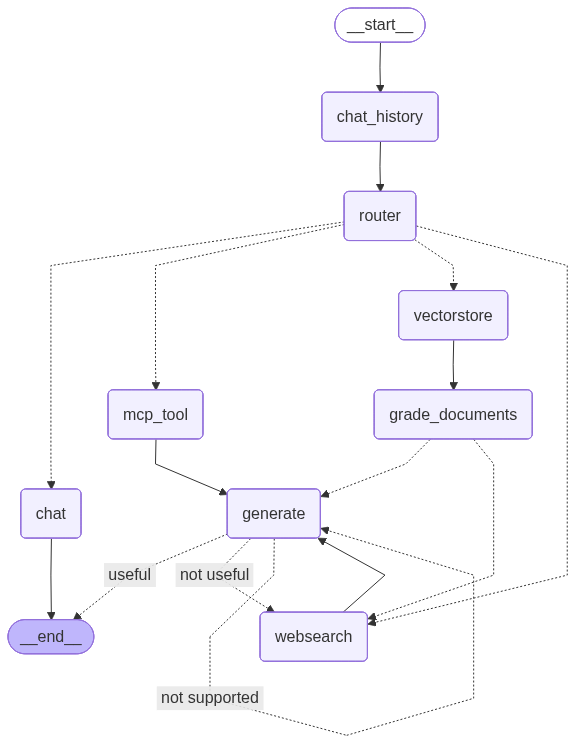

In [151]:
from IPython.display import Image, display
# app = workflow.compile(checkpointer=checkpointer)
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("error")
    # This requires some extra dependencies and is optional
    pass

In [152]:
session_id, config = load_session_id()
recursion_limit = 12

In [153]:
# previous_state = app.get_state(config)
# previous_state
# config = {'configurable': {'thread_id': '150e1c9a-8ff9-4b3f-8b54-7fbfb3ede6a9'}, 'recursion_limit': 12}

final_config = RunnableConfig(
    configurable={"thread_id": session_id},
    recursion_limit=recursion_limit
)

# Agent Execution

This section demonstrates how to interact with the compiled AI agent by providing a user question and streaming the output.

In [155]:
# Compile
# app = workflow.compile()

# Test
from pprint import pprint

user_input = HumanMessage(content="List all servers in RTP")
inputs = {"question": user_input, "tools": tools}

for output in app.stream(inputs, final_config):
    print(config)
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

print("------------------------------************--------------------------------")
pprint(value["generation"])

---Loading chat history---
{'configurable': {'thread_id': '22afad25-f1d8-4be3-b38a-c1a5de9f86ca'}}
'Finished running: chat_history:'
---ROUTE QUESTION---
{'tool_calls': [{'name': 'get_compute_rackunits_by_site', 'parameters': {'site': 'rtp'}}], 'datasource': 'tool'}
tool
---DECISION: ROUTE QUESTION TO TOOL---
{'configurable': {'thread_id': '22afad25-f1d8-4be3-b38a-c1a5de9f86ca'}}
'Finished running: router:'
---Sending request to MCP tool---
func_name, func_params {'site': 'rtp'} get_compute_rackunits_by_site
hi im here after tool call
{'configurable': {'thread_id': '22afad25-f1d8-4be3-b38a-c1a5de9f86ca'}}
'Finished running: mcp_tool:'
---GENERATE---
LLM output The servers in RTP are: rtp-ai1-srv1, rtp-ai1-srv2, rtp-ai1-srv3, rtp-ai1-srv4, rtp-ai1-srv5, rtp-ai1-srv6, and rtp-ai1-strg1. These servers have management IP addresses in the 198.19.223 range. They are all located in the RTP site.
---CHECK HALLUCINATIONS---
---DECISION: ANSWER IS GROUNDED IN DOCUMENTS - NO HALLUCINATIONS---
---